In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('code')

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import pickle
import argparse
import copy
import json
from model.model_utils import ModeKeys
from model.model_registrar import ModelRegistrar
from model.dyn_stg import SpatioTemporalGraphCVAEModel

In [4]:
def load_model(model_dir, example_scene, ts=1999, ume=False):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)
    hyperparams['minimum_history_length'] = 8
    hyperparams['maximum_history_length'] = 8
    
    stg = SpatioTemporalGraphCVAEModel(None, model_registrar,
                                                hyperparams,
                                                None, 'cpu')


    stg.set_scene_graph(example_scene)

    stg.set_annealing_params()
    
    return stg, hyperparams

In [5]:
def load_data(data_dir, data_dict_name):
    eval_data_path = os.path.join(data_dir, data_dict_name)
    with open(eval_data_path, 'rb') as f:
        scenes = pickle.load(f, encoding='latin1')
    return scenes

In [6]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

# Load Model

In [7]:
output = dict()
state = ['position', 'velocity', 'acceleration']
dims = ['x', 'y']

In [8]:
dataset_name = 'eth_univ'
data_dir = 'data/%s' % dataset_name
eval_data_dict_name = '%s_n_test.pkl' % dataset_name
train_data_dict_name = '%s_train.pkl' % dataset_name
log_dir = '.'
model_dir = '.'

In [1]:
eval_scenes = load_data(data_dir, eval_data_dict_name)
eval_stg, hyperparams = load_model(model_dir, eval_scenes[0], ts=599, ume=False)

NameError: name 'load_data' is not defined

In [10]:
cvae = list(eval_stg.node_models_dict.values())[0] # Only one edge type

## p_z_x weights

In [11]:
output['weight'] = (cvae.node_modules[cvae.node_type + '/hx_to_z'].weight.data.cpu().numpy().T)
output['weight'].shape

(32, 10)

In [12]:
output['bias'] = (cvae.node_modules[cvae.node_type + '/hx_to_z'].bias.data.cpu().numpy().T)
output['bias'].shape

(10,)

In [11]:
scene = eval_scenes[0]
batch_size = 50
timesteps = scene.sample_timesteps(batch_size)

In [11]:
predictions = eval_stg.predict(scene, timesteps, 12, num_samples=0, min_future_timesteps=0)

NameError: name 'scene' is not defined

In [ ]:
output['features'] = cvae.dst_features
output['features'].shape

In [16]:
(inputs, 
 first_history_indices, 
 timesteps_in_scene, 
 node_scene_graph_batched, 
 nodes) = eval_stg.get_input(scene, timesteps, None, 0)
c = list()
for i, input in enumerate(inputs):
    _, scene_graph = node_scene_graph_batched[i]
    neighbors_via_edge_type = scene_graph.neigbors_via_edge_type[nodes[i]]
    if not neighbors_via_edge_type:
        c.append((input, []))
        continue
    neighbors = list(neighbors_via_edge_type.values())[0] # Only one edge type
    neighbor_state_list = list()
    for neighbor in neighbors:
        neighbor_state = neighbor.get(np.array([timesteps_in_scene[i] - 8, timesteps_in_scene[i]]),
                                             state, dims,
                                             padding=0.0)
        neighbor_state_list.append(neighbor_state)
    c.append((input, neighbor_state_list))
    
output['c'] = c
len(output['c'])

203

In [17]:
from utils import prediction_output_to_trajectories
output_dict, histories_dict, futures_dict = prediction_output_to_trajectories(predictions, 
                                                                              dt=0.4, 
                                                                              max_h=8, 
                                                                              ph=12)
output_list = list()
for outputs_t in output_dict.values():
    for outputs_by_node in outputs_t.values():
        output_list.append(outputs_by_node)
        
future_list = list()
for futures_t in futures_dict.values():
    for futures_by_node in futures_t.values():
        future_list.append(futures_by_node)
        
output['x'] = output_list
print(len(output_list))
print(output_list[0].shape)

output['gt'] = future_list
print(len(future_list))
print(future_list[0].shape)

203
(25, 12, 2)
203
(2, 2)


In [18]:
output['alpha_p'] = cvae.latent.p_dist.probs.detach().numpy()
output['alpha_p'].shape

(203, 2, 5)

In [19]:
output['z_one_hot'] = np.expand_dims(cvae.latent.all_one_hot_combinations(cvae.latent.N, cvae.latent.K), 1).repeat(203, 1)
output['z_one_hot'].shape

(25, 203, 10)

In [20]:
with open('./dst_test_nominf.pkl', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
print(f"weight:\t\t array with shape: {output['weight'].shape}")
print(f"bias:\t\t array with shape: {output['bias'].shape}")
print(f"features:\t array with shape: {output['features'].shape}")
print(f"c:\t\t list with len: {len(output['c'])} of tuples (node_traj, [neighbor_traj]) each shape {output['c'][0][0].shape}")
print(f"x:\t\t list with len: {len(output['x'])} each of shape: {output['x'][0].shape}")
print(f"gt:\t\t list with len: {len(output['gt'])} each of variable first-dim shape: {output['gt'][1].shape}")
print(f"alpha_p:\t array with shape: {output['alpha_p'].shape}")
print(f"z_one_hot:\t array with shape: {output['z_one_hot'].shape}")

weight:		 array with shape: (32, 10)
bias:		 array with shape: (10,)
features:	 array with shape: torch.Size([203, 32])
c:		 list with len: 203 of tuples (node_traj, [neighbor_traj]) each shape (9, 6)
x:		 list with len: 203 each of shape: (25, 12, 2)
gt:		 list with len: 203 each of variable first-dim shape: (12, 2)
alpha_p:	 array with shape: (203, 2, 5)
z_one_hot:	 array with shape: (25, 203, 10)


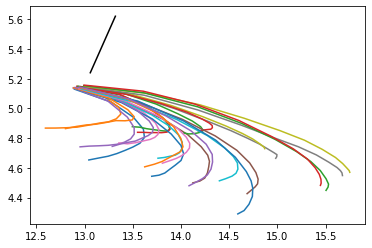

In [21]:
import matplotlib.pyplot as plt

for z_id in range(output['x'][0].shape[0]):
    plt.plot(output['x'][0][z_id, :, 0], output['x'][0][z_id, :, 1])
    
plt.plot(output['gt'][0][:, 0], output['gt'][0][:, 1], color='k')
# print(output['gt'])

In [14]:
with open('./filtered_alpha_p_sparsemax_nominf.pkl', 'rb') as f:
    filtered_alpha_sm = pickle.load(f, encoding='latin1')

In [15]:
filtered_alpha_sm.shape

(203, 2, 5)

In [16]:
predictions_sm = eval_stg.predict(scene, timesteps, 12, num_samples=2000, min_future_timesteps=0)

In [17]:
import evaluation
(eval_mse_batch_errors_sm,
 eval_fde_batch_errors_sm,
 eval_kde_nll_sm,
 eval_obs_batch_viols_sm) = evaluation.compute_batch_statistics(predictions_sm,
                     0.4,
                     max_hl=8,
                     ph=12)

In [18]:
print('Sparsemax')
print(f"KDE: {eval_kde_nll_sm.mean()} +- {eval_kde_nll_sm.std() / np.sqrt(eval_kde_nll_sm.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_sm.mean()} +- {eval_mse_batch_errors_sm.std() / np.sqrt(eval_mse_batch_errors_sm.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_sm.mean()} +- {eval_fde_batch_errors_sm.std() / np.sqrt(eval_fde_batch_errors_sm.shape[0])}")

Sparsemax
KDE: 6.180768115218773 +- 0.5165102220336549
MSE: 0.5434364639052025 +- 0.0005553032316710001
FDE: 1.0925287333207392 +- 0.00136853621572599


In [19]:
with open('./filtered_alpha_p_nominf.pkl', 'rb') as f:
    filtered_alpha = pickle.load(f, encoding='latin1')

In [20]:
filtered_alpha.shape

(203, 2, 5)

In [21]:
predictions = eval_stg.predict(scene, timesteps, 12, num_samples=2000, min_future_timesteps=0)

In [22]:
import evaluation
(eval_mse_batch_errors,
 eval_fde_batch_errors,
 eval_kde_nll,
 eval_obs_batch_viols) = evaluation.compute_batch_statistics(predictions,
                     0.4,
                     max_hl=8,
                     ph=12)

In [ ]:
import visualization

fig, ax = plt.subplots(3, 2,figsize=(10, 15))

kde_fde_pd = {'dataset': ['ETH'] * eval_kde_nll.shape[0],
                          'kde_nll': eval_kde_nll.tolist()}
visualization.visualization_utils.plot_barplots(ax[0][0], kde_fde_pd, 'dataset', 'kde_nll')

mse_fde_pd = {'dataset': ['ETH'] * eval_mse_batch_errors.shape[0],
              'mse': eval_mse_batch_errors.tolist(),
              'fde': eval_fde_batch_errors.tolist()}

visualization.visualization_utils.plot_boxplots(ax[1, 0], mse_fde_pd, 'dataset', 'mse')
visualization.visualization_utils.plot_boxplots(ax[2][0], mse_fde_pd, 'dataset', 'fde')

In [23]:
predictions_alpha_p = eval_stg.predict(scene, timesteps, 12, num_samples=2000, min_future_timesteps=0, sample_probs=torch.tensor(filtered_alpha).float())

Sample Probs are used!


In [24]:
import evaluation
(eval_mse_batch_errors_dst,
 eval_fde_batch_errors_dst,
 eval_kde_nll_dst,
 eval_obs_batch_viols_dst) = evaluation.compute_batch_statistics(predictions_alpha_p,
                     0.4,
                     max_hl=8,
                     ph=12)

NameError: name 'eval_kde_nll1' is not defined

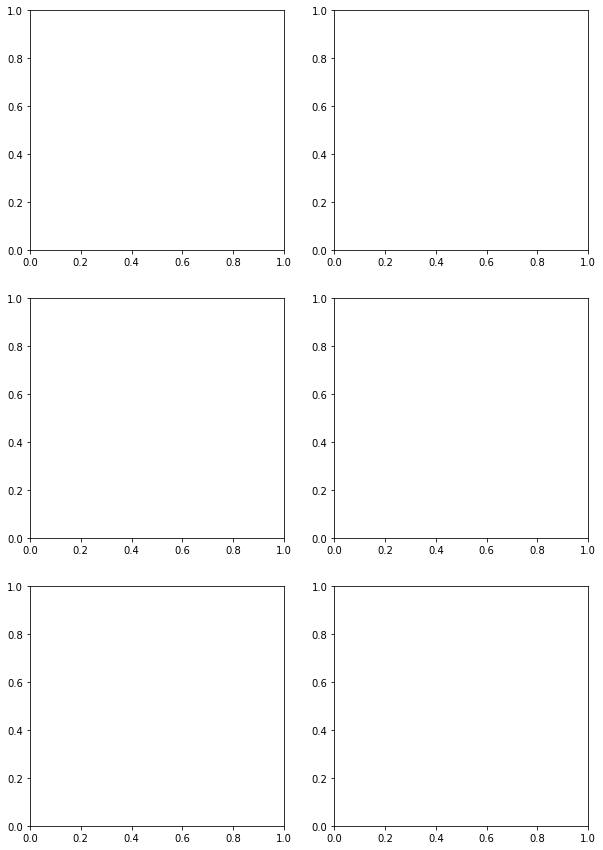

In [30]:
fig, ax = plt.subplots(3, 2,figsize=(10, 15))
kde_fde_pd1 = {'dataset': ['ETH'] * eval_kde_nll1.shape[0],
                          'kde_nll': eval_kde_nll1.tolist()}

visualization.visualization_utils.plot_barplots(ax[0, 1], kde_fde_pd1, 'dataset', 'kde_nll')


mse_fde_pd1 = {'dataset': ['ETH'] * eval_mse_batch_errors1.shape[0],
              'mse': eval_mse_batch_errors1.tolist(),
              'fde': eval_fde_batch_errors1.tolist()}

visualization.visualization_utils.plot_boxplots(ax[1, 1], mse_fde_pd1, 'dataset', 'mse')

visualization.visualization_utils.plot_boxplots(ax[2, 1], mse_fde_pd1, 'dataset', 'fde')
fig.savefig('plot.png')

In [ ]:
eval_mse_batch_errors1.shape

In [ ]:
eval_mse_batch_errors

In [ ]:
203*3

In [25]:
print('Softmax')
print(f"KDE: {eval_kde_nll.mean()} +- {eval_kde_nll.std() / np.sqrt(eval_kde_nll.shape[0])}")
print(f"MSE: {eval_mse_batch_errors.mean()} +- {eval_mse_batch_errors.std() / np.sqrt(eval_mse_batch_errors.shape[0])}")
print(f"FDE: {eval_fde_batch_errors.mean()} +- {eval_fde_batch_errors.std() / np.sqrt(eval_fde_batch_errors.shape[0])}")

Softmax
KDE: 6.326980415686784 +- 0.5222250364846241
MSE: 0.5439091316622618 +- 0.0005564925549808558
FDE: 1.093054784375964 +- 0.001369823009628328


In [26]:
print('DST')
print(f"KDE: {eval_kde_nll_dst.mean()} +- {eval_kde_nll_dst.std() / np.sqrt(eval_kde_nll_dst.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_dst.mean()} +- {eval_mse_batch_errors_dst.std() / np.sqrt(eval_mse_batch_errors_dst.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_dst.mean()} +- {eval_fde_batch_errors_dst.std() / np.sqrt(eval_fde_batch_errors_dst.shape[0])}")

DST
KDE: 6.97936250143831 +- 0.5470969095208453
MSE: 0.54291791919502 +- 0.0005488968243377719
FDE: 1.0913947566446054 +- 0.0013547291873768224


# Best of 5

In [15]:
predictions_best_5 = eval_stg.predict(scene, timesteps, 12, most_likely_z=True, num_samples=1, min_future_timesteps=0)

True
Most Likely 5
(2500, 203, 12, 2)


In [16]:
import evaluation
(eval_mse_batch_errors_bo5,
 eval_fde_batch_errors_bo5,
 eval_kde_nll_bo5,
 eval_obs_batch_viols_bo5) = evaluation.compute_batch_statistics(predictions_best_5,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True)

In [17]:
print('Best of 5 Mean GMM Softmax')
print(f"KDE: {eval_kde_nll_bo5.mean()} +- {eval_kde_nll_bo5.std() / np.sqrt(eval_kde_nll_bo5.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5.mean()} +- {eval_mse_batch_errors_bo5.std() / np.sqrt(eval_mse_batch_errors_bo5.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5.mean()} +- {eval_fde_batch_errors_bo5.std() / np.sqrt(eval_fde_batch_errors_bo5.shape[0])}")

Best of 5 Mean GMM Softmax
KDE: 15.689808904588585 +- 0.47378699294368165
MSE: 0.42439600979345143 +- 0.02279648744796937
FDE: 0.8747269030938155 +- 0.05691327116667076


In [28]:
eval_kde_nll_bo5.shape

(181,)

In [18]:
with open('./filtered_alpha_p_sparsemax.pkl', 'rb') as f:
    filtered_alpha_sm = pickle.load(f, encoding='latin1')

In [19]:
predictions_best_5_sm = eval_stg.predict(scene, timesteps, 12, most_likely_z=True, num_samples=1, min_future_timesteps=0, sample_probs=torch.tensor(filtered_alpha_sm).float())

True
Sample Probs are used!
Most Likely 5
(2500, 203, 12, 2)


In [20]:
import evaluation
(eval_mse_batch_errors_bo5_sm,
 eval_fde_batch_errors_bo5_sm,
 eval_kde_nll_bo5_sm,
 eval_obs_batch_viols_bo5_sm) = evaluation.compute_batch_statistics(predictions_best_5_sm,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True)

In [21]:
print('Best of 5 Mean GMM Sparsemax')
print(f"KDE: {eval_kde_nll_bo5_sm.mean()} +- {eval_kde_nll_bo5_sm.std() / np.sqrt(eval_kde_nll_bo5_sm.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5_sm.mean()} +- {eval_mse_batch_errors_bo5_sm.std() / np.sqrt(eval_mse_batch_errors_bo5_sm.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5_sm.mean()} +- {eval_fde_batch_errors_bo5_sm.std() / np.sqrt(eval_fde_batch_errors_bo5_sm.shape[0])}")

Best of 5 Mean GMM Sparsemax
KDE: 16.246392445028707 +- 0.4097121283261621
MSE: 0.427664469852845 +- 0.022635578948948486
FDE: 0.8628703576382771 +- 0.054581477569129816


In [23]:
with open('./filtered_alpha_p.pkl', 'rb') as f:
    filtered_alpha_p = pickle.load(f, encoding='latin1')

In [24]:
predictions_best_5_dst = eval_stg.predict(scene, timesteps, 12, most_likely_z=True, num_samples=1, min_future_timesteps=0, sample_probs=torch.tensor(filtered_alpha_p).float())

True
Sample Probs are used!
Most Likely 5
(2500, 203, 12, 2)


In [25]:
import evaluation
(eval_mse_batch_errors_bo5_dst,
 eval_fde_batch_errors_bo5_dst,
 eval_kde_nll_bo5_dst,
 eval_obs_batch_viols_bo5_dst) = evaluation.compute_batch_statistics(predictions_best_5_dst,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True)

In [26]:
print('Best of 5 Mean GMM DST')
print(f"KDE: {eval_kde_nll_bo5_dst.mean()} +- {eval_kde_nll_bo5_dst.std() / np.sqrt(eval_kde_nll_bo5_dst.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5_dst.mean()} +- {eval_mse_batch_errors_bo5_dst.std() / np.sqrt(eval_mse_batch_errors_bo5_dst.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5_dst.mean()} +- {eval_fde_batch_errors_bo5_dst.std() / np.sqrt(eval_fde_batch_errors_bo5_dst.shape[0])}")

Best of 5 Mean GMM DST
KDE: 16.24127019381913 +- 0.44455136099065856
MSE: 0.4136614873995376 +- 0.02201399092610776
FDE: 0.8485441412992353 +- 0.05472369853865348


# All z post selection

In [75]:
from scipy.integrate import cumtrapz
def integrate_trajectory(v, x0, dt):
    xd_ = cumtrapz(v[..., 0], axis=1, dx=dt) + x0[0]
    yd_ = cumtrapz(v[..., 1], axis=1, dx=dt) + x0[1]
    integrated = np.stack([xd_, yd_], axis=2)
    return integrated
def prediction_output_to_trajectories(prediction_output_dict, dt, max_h, ph, map=None, prune_ph_to_future=False, z_index=None):
    prediction_timesteps = prediction_output_dict.keys()

    output_dict = dict()
    histories_dict = dict()
    futures_dict = dict()
    bi = 0
    for t in prediction_timesteps:
        histories_dict[t] = dict()
        output_dict[t] = dict()
        futures_dict[t] = dict()
        prediction_nodes = prediction_output_dict[t].keys()
        for node in prediction_nodes:
            predictions_output = prediction_output_dict[t][node]
            if node.is_robot:
                continue
            history = node.get(np.array([t - max_h, t]), ['position'], ['x', 'y'])  # History includes current pos
            history = history[~np.isnan(history.sum(axis=1))]

            future = node.get(np.array([t + 1, t + ph]), ['position'], ['x', 'y'])
            future = future[~np.isnan(future.sum(axis=1))]

            current_pos = node.get(t, ['position'], ['x', 'y'])[0]  # List with single item
            current_vel = node.get(t, ['velocity'], ['x', 'y'])[0]  # List with single item

            predictions_output = predictions_output.reshape(25, 2000, 12, 2).mean(axis=1)
            if z_index is not None:
                predictions_output = predictions_output[z_index[bi]]
            bi += 1

            if prune_ph_to_future:
                predictions_output = predictions_output[:, :future.shape[0]]
                if predictions_output.shape[1] == 0:
                    continue

            vel_broad = np.expand_dims(np.broadcast_to(current_vel, (predictions_output.shape[0], current_vel.shape[-1])), axis=-2)
            vel = np.concatenate((vel_broad, predictions_output), axis=1)

            if map is None:
                histories_dict[t][node] = history
                output_dict[t][node] = integrate_trajectory(vel, current_pos, dt=dt)
                futures_dict[t][node] = future
            else:
                histories_dict[t][node] = map.to_map_points(history)
                output_dict[t][node] = map.to_map_points(integrate_trajectory(vel, current_pos, dt=dt))
                futures_dict[t][node] = map.to_map_points(future)

    return output_dict, histories_dict, futures_dict

In [16]:
from evaluation.evaluation import compute_mse, compute_fde, compute_kde_nll, compute_obs_violations
def compute_batch_statistics(prediction_output_dict, dt, max_hl, ph, map=None, best_of=False, z_index=None):

    (prediction_dict,
     _,
     futures_dict) = prediction_output_to_trajectories(prediction_output_dict, dt, max_hl, ph, prune_ph_to_future=True, z_index=z_index)

    batch_error_dict = {'mse': list(), 'fde': list(), 'kde': list(), 'obs_viols': list()}

    for t in prediction_dict.keys():
        for node in prediction_dict[t].keys():
            mse_errors = compute_mse(prediction_dict[t][node], futures_dict[t][node])
            fde_errors = compute_fde(prediction_dict[t][node], futures_dict[t][node])
            kde_ll = compute_kde_nll(prediction_dict[t][node], futures_dict[t][node])
            if map is not None:
                obs_viols = compute_obs_violations(prediction_dict[t][node], map)
            else:
                obs_viols = 0
            if best_of:
                mse_errors = np.min(mse_errors)
                fde_errors = np.min(fde_errors)
                kde_ll = np.min(kde_ll)
            batch_error_dict['mse'].append(mse_errors)
            batch_error_dict['fde'].append(fde_errors)
            batch_error_dict['kde'].append(kde_ll)
            batch_error_dict['obs_viols'].append(obs_viols)

    return (np.hstack(batch_error_dict['mse']),
            np.hstack(batch_error_dict['fde']),
            np.hstack(batch_error_dict['kde']),
            np.hstack(batch_error_dict['obs_viols']))

In [12]:
with torch.no_grad():
    predictions_all_z = eval_stg.predict(scene, timesteps, 12, num_samples=0, min_future_timesteps=0)

All z is used!
0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
(50000, 203, 12, 2)


In [26]:
cvae = list(eval_stg.node_models_dict.values())[0]
alpha_p_softmax = cvae.latent.p_dist.probs.cpu().detach().numpy()
alpha_p_softmax.shape

(203, 2, 5)

In [24]:
all_one_hot = cvae.latent.all_one_hot_combinations(2, 5).reshape(1, -1, 2, 5)
joint_prob = (np.expand_dims(alpha_p_softmax, axis=1) * all_one_hot).sum(axis=-1).prod(axis=-1)
argmax_idxs = np.argsort(joint_prob, axis=1)[..., ::-1][..., :5]

In [76]:
(eval_mse_batch_errors_bo5,
 eval_fde_batch_errors_bo5,
 eval_kde_nll_bo5,
 eval_obs_batch_viols_bo5) = compute_batch_statistics(predictions_all_z,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True,
                                                                z_index=argmax_idxs)

In [77]:
print('Best of 5 Mean GMM Softmax')
print(f"KDE: {eval_kde_nll_bo5.mean()} +- {eval_kde_nll_bo5.std() / np.sqrt(eval_kde_nll_bo5.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5.mean()} +- {eval_mse_batch_errors_bo5.std() / np.sqrt(eval_mse_batch_errors_bo5.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5.mean()} +- {eval_fde_batch_errors_bo5.std() / np.sqrt(eval_fde_batch_errors_bo5.shape[0])}")

Best of 5 Mean GMM Softmax
KDE: 16.69244378009929 +- 0.40906177873518296
MSE: 0.37551021795521533 +- 0.020517681545160125
FDE: 0.7568273285076677 +- 0.048938780837849874


In [45]:
with open('./filtered_alpha_p_sparsemax.pkl', 'rb') as f:
    filtered_alpha_sm = pickle.load(f, encoding='latin1')

In [46]:
all_one_hot = cvae.latent.all_one_hot_combinations(2, 5).reshape(1, -1, 2, 5)
joint_prob = (np.expand_dims(filtered_alpha_sm, axis=1) * all_one_hot).sum(axis=-1).prod(axis=-1)
argmax_idxs_sm = np.argsort(joint_prob, axis=1)[..., ::-1][..., :5]

In [78]:
(eval_mse_batch_errors_bo5_sm,
 eval_fde_batch_errors_bo5_sm,
 eval_kde_nll_bo5_sm,
 eval_obs_batch_viols_bo5_sm) = compute_batch_statistics(predictions_all_z,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True, z_index=argmax_idxs_sm)

In [79]:
print('Best of 5 Mean GMM Sparsemax')
print(f"KDE: {eval_kde_nll_bo5_sm.mean()} +- {eval_kde_nll_bo5_sm.std() / np.sqrt(eval_kde_nll_bo5_sm.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5_sm.mean()} +- {eval_mse_batch_errors_bo5_sm.std() / np.sqrt(eval_mse_batch_errors_bo5_sm.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5_sm.mean()} +- {eval_fde_batch_errors_bo5_sm.std() / np.sqrt(eval_fde_batch_errors_bo5_sm.shape[0])}")

Best of 5 Mean GMM Sparsemax
KDE: 14.770436071681099 +- 0.5036767759537559
MSE: 0.3970539493802833 +- 0.021159917138804836
FDE: 0.8019804907502585 +- 0.05124428002597904


In [54]:
with open('./filtered_alpha_p.pkl', 'rb') as f:
    filtered_alpha_p = pickle.load(f, encoding='latin1')

In [55]:
all_one_hot = cvae.latent.all_one_hot_combinations(2, 5).reshape(1, -1, 2, 5)
joint_prob = (np.expand_dims(filtered_alpha_p, axis=1) * all_one_hot).sum(axis=-1).prod(axis=-1)
argmax_idxs_dst = np.argsort(joint_prob, axis=1)[..., ::-1][..., :5]

In [80]:
(eval_mse_batch_errors_bo5_dst,
 eval_fde_batch_errors_bo5_dst,
 eval_kde_nll_bo5_dst,
 eval_obs_batch_viols_bo5_dst) = compute_batch_statistics(predictions_all_z,
                     0.4,
                     max_hl=8,
                     ph=12,
                                                                best_of=True,z_index=argmax_idxs_dst)

In [81]:
print('Best of 5 Mean GMM DST')
print(f"KDE: {eval_kde_nll_bo5_dst.mean()} +- {eval_kde_nll_bo5_dst.std() / np.sqrt(eval_kde_nll_bo5_dst.shape[0])}")
print(f"MSE: {eval_mse_batch_errors_bo5_dst.mean()} +- {eval_mse_batch_errors_bo5_dst.std() / np.sqrt(eval_mse_batch_errors_bo5_dst.shape[0])}")
print(f"FDE: {eval_fde_batch_errors_bo5_dst.mean()} +- {eval_fde_batch_errors_bo5_dst.std() / np.sqrt(eval_fde_batch_errors_bo5_dst.shape[0])}")

Best of 5 Mean GMM DST
KDE: 16.164927721641984 +- 0.44140661018015553
MSE: 0.37610120968952954 +- 0.021348656415892
FDE: 0.7533120586257447 +- 0.05036671190883169
